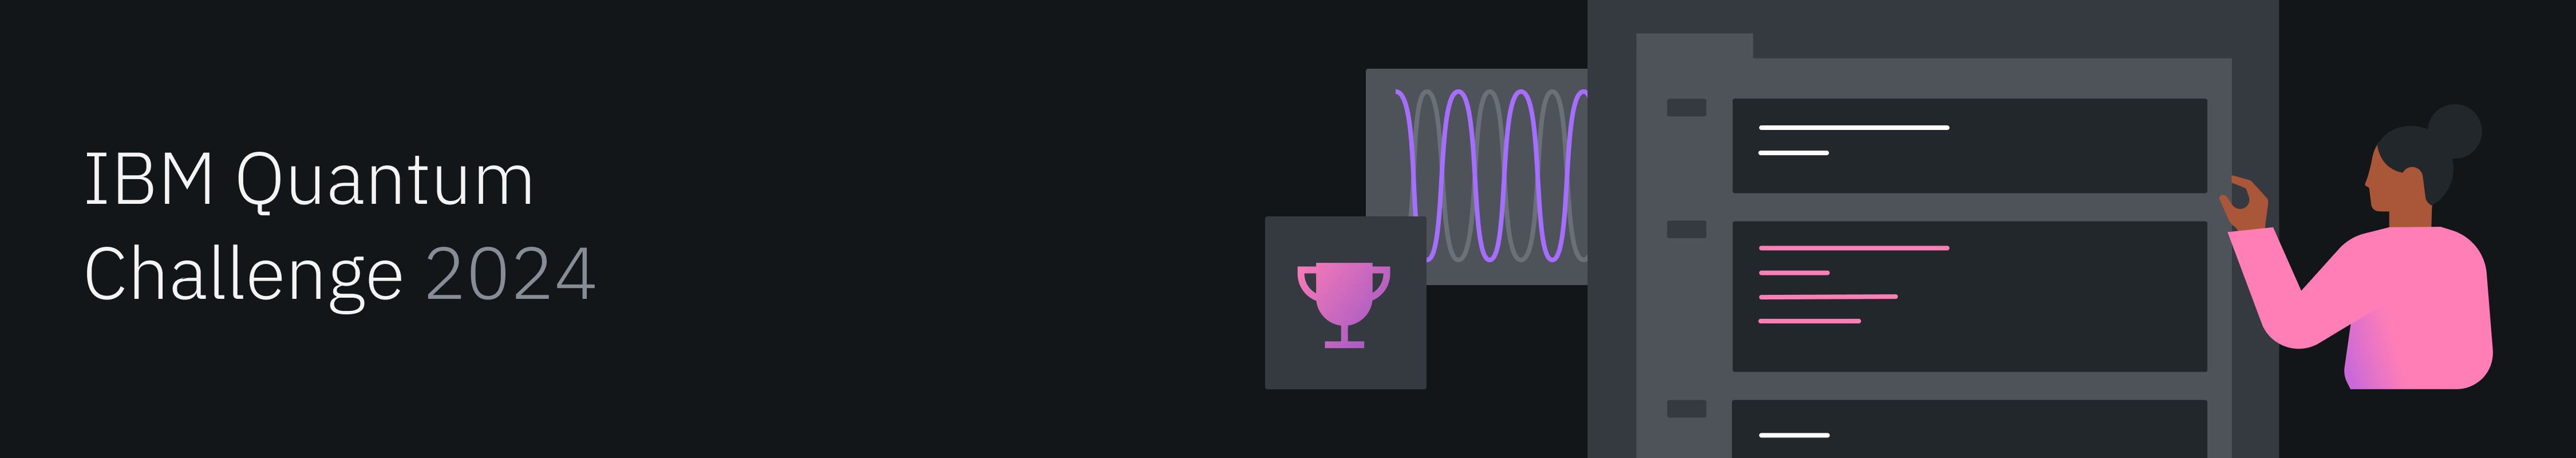

# Circuit Kinitting Toolboxを使ってみる(2024年 Lab3)

## Setup

いつものように、オプションのインストールから始めます。

In [1]:
# ### Install Qiskit and relevant packages, if needed
# ### IMPORTANT: Make sure you are using python 3.10 or 3.11 for compatibility of the required packages
# %pip install qiskit[visualization]==1.0.2
# %pip install qiskit-ibm-runtime
# %pip install qiskit-aer
# %pip install qiskit-transpiler-service
# %pip install graphviz
# %pip install circuit-knitting-toolbox
# %pip install qiskit-serverless -U

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map
from qiskit.quantum_info import SparsePauliOp

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from circuit_knitting.cutting import generate_cutting_experiments, cut_gates

## はじめに

Lab 3 へようこそ！ 本日は、Qiskit スタック用に開発されているエキサイティングな新機能の一部を、特別にご紹介します。この教育的な Challenge は notebook が分かれていて、それぞれがユニークで画期的なイノベーションを紹介し、これらの新機能を探索しテストを促します。複雑な量子回路を簡素化する Circuit Knitting Toolboxのようなツールを探求し、Qiskit Serverless で量子コンピューティングと古典コンピューティングのシームレスな統合をセットアップするワークフローを体験し、AI-Powered Transpiler Passes と コード生成と回路最適化のための Qiskit Code Assistant のような AI 搭載ツールを活用するチャンスがあります。これらのイノベーションが量子開発にどのような革命をもたらすのか、ぜひご覧ください！

```{warning}
これらの機能は **ベータ版およびリリースプレビュー版** であるため、バグに遭遇する可能性が高いことにご注意ください。量子開発の限界に挑戦してください！
```

## Circuit Knitting Toolbox の紹介

この Notebook では、 **Circuit Knitting Toolbox** について詳しく説明します。 これは、複雑な量子回路を簡素化するために使用できるツールです。

IBM が量子コンピューターで使用しているような超伝導プロセッサには、接続性が限られているのは事実です。つまり、科学の限界を押し広げるには、その限界を克服するために創造性を発揮する必要があります。

自然な疑問は、どうすればこれを克服できるかということです。 ひとつの解決策は、Circuit Knitting です。

Lab 2 で学んだように、離れた量子ビット間にゲートを適用すると、大きな SWAP オーバーヘッドが必要になります。 Circuit Cutting は、大きな量子回路のゲートやワイヤーを切断することで、SWAP ゲートの必要性を減らす技術です。 これにより、量子ハードウェアの制約内で実行可能な小さな回路に分解されます。 そして、これらの小さな回路の結果を組み合わせて、元の問題の結果を再構築します。

つまり、Circuit Cutting を使用すると、サンプリングのオーバーヘッドが追加される代わりに、量子ハードウェア上でより大きな回路を実行することができます。

![Circuit Knitting](./resources/2024-spring-lab3-circuit_knitting.png)

### 理論


量子チャネル $\varepsilon$ は、係数 $a_i$ を持つ複数のチャネル $\varepsilon_i$ の線形結合に分解できます。したがって、仮想ゲートも複数の回路の合計によって実装されます:

$$\varepsilon(\cdot) = \sum_i a_i \varepsilon(\cdot)$$

一部の $a_i$ は、$a_i<0$ のためサンプリングできず、$a_i$ は有効な確率分解を形成しません。次の方法で有効な確率分布に変換します:

$$\gamma = \sum   |a_i| $$


したがって、$\sum\frac{|a_i|}{\gamma}=1$ です。よって、$\frac{|a_i|}{\gamma}$ は有効な確率分布を形成します:

$$\varepsilon(\rho) =\gamma \sum_i \frac{|a_i|}{\gamma} sign(a_i) \varepsilon_i(\cdot)$$

これが Quasi-Probability Decomposition (擬確率分解)であり、これによって、私たちはゲートをカットすることができます。

詳細については、 [explanatory material for the circuit cutting module](https://qiskit-extensions.github.io/circuit-knitting-toolbox/circuit_cutting/explanation/index.html) を参照してください。

### CNOT ゲートのカット

次に、量子ビットが離れた状態のベル・ペアに焦点を当ててみましょう。 このシナリオで Circuit Knitting Toolbox を使ってCNOTゲートをカットする方法を探ります。

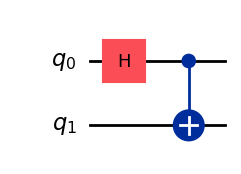

In [3]:
# create a bell pair
bell_state = QuantumCircuit(2)
bell_state.h(0)
bell_state.cx(0,1)
bell_state.draw("mpl")

次に、これを `ibm_kyoto` で実行します！ この Lab の残りの部分では `ibm_kyoto` デバイスを使います。

In [4]:
## If this is your first time accessing the backend
## remove # and fill your API key, and run the code
#service = QiskitRuntimeService(
#    channel='ibm_quantum',
#    instance='ibm-q/open/main',
#    token='<IBM Quantum API key>'
#)

service = QiskitRuntimeService(channel="ibm_quantum")

# Specify a system to use for transpilation, DO NOT change
backend = service.backend("ibm_kyoto")

ここで、量子ビット122と126の間のゲートを実行するために多くのSWAPを必要とし、そして量子ビットを初期位置に戻すために多くのSWAPを必要とするレイアウトを選択します。

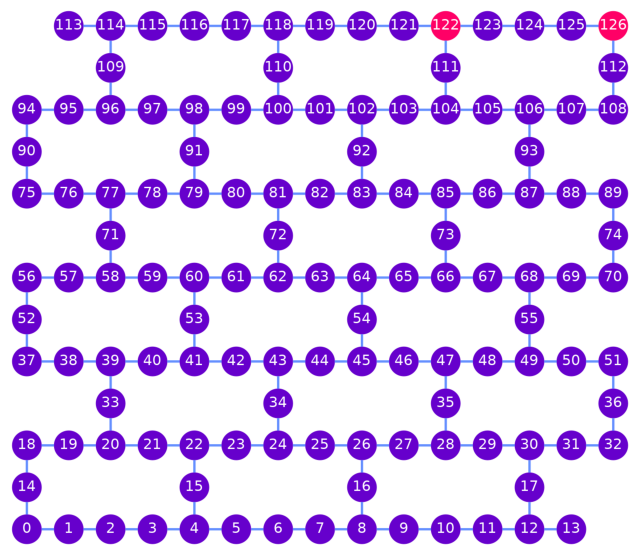

In [5]:
layout=[122, 126]
qubit_color = []
for i in range(127):
    if i in layout:
        qubit_color.append("#ff0066")
    else:
        qubit_color.append("#6600cc")
plot_gate_map(backend, qubit_color=qubit_color, qubit_size=60, font_size=25, figsize=(8,8))

ベル・ペア回路をトランスパイルして、デバイスが理解し実行できる ISA (Instruction Set Architecture) 回路を得ます。

Transpiled circuit depth:  27


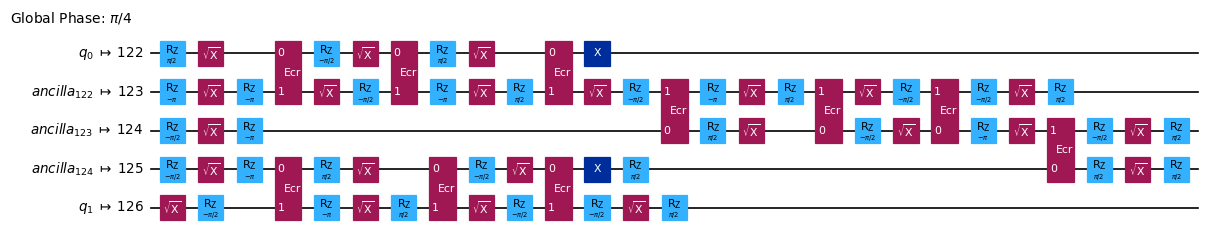

In [6]:
# transpile the circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, initial_layout=layout, seed_transpiler=0)
isa_qc = pm.run(bell_state)

# original circuit depth
isa_qc_depth = isa_qc.depth()
print(f"Transpiled circuit depth: ", isa_qc_depth)
isa_qc.draw("mpl", scale=0.6, idle_wires=False, fold=False)

多くの ancilla 量子ビットが使用され、トランスパイルされた回路の深さは27であることがわかります！これはQiskit Circuit Knitting Toolbox を使わない場合です。

### Circuit Knitting


離れたゲート(非ローカル量子ビットの122と126を接続するゲート）を、インデックスを指定して `TwoQubitQPDGate` に置き換えます。
> [QPD](https://qiskit-extensions.github.io/circuit-knitting-toolbox/circuit_cutting/explanation/index.html#circuit-cutting-as-a-quasiprobability-decomposition-qpd) は、理論の章で説明した擬確率分解 (Quasi-Probability Decomposition) のことです。

`cut_gates` 関数は、インデックスで指定されたゲートを`TwoQubitQPDGate` に置き換え、ゲート分解ごとに 1 つずつ、 `QPDBasis` インスタンスのリストも返します。  
``QPDBasis`` オブジェクトは、カットされたゲートをどのように単一量子ビット演算に分解するかの情報を含んでいます。 詳細は ["Error mitigation for short-depth quantum circuits"](https://arxiv.org/pdf/1612.02058) を参照してください。    

次のセルでは、カットするゲートのインデックスを指定して、ベル・ペア回路に `cut_gates` 関数を適用し、CNOTゲートがカットされた回路を取得します。

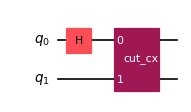

In [7]:
gates_connecting_to_cut = {0, 1}

# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(bell_state.data)
    if {bell_state.find_bit(q)[0] for q in instruction.qubits} == gates_connecting_to_cut
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(bell_state, cut_indices)

qpd_circuit.draw("mpl", scale=0.6)

````{note}
```python
    for i, instruction in enumerate(bell_state.data)
    if {bell_state.find_bit(q)[0] for q in instruction.qubits} == gates_connecting_to_cut
```
上記の部分は構築したベル・ペア回路 `bell_state` における命令（量子ゲート操作）が、どの量子ビットに対して作用しているかをまず確認しています（今回は`H`と`CX`ゲート）。  

```python
bell_state.data

"""
[
 CircuitInstruction(operation=Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0),), clbits=()), 
 CircuitInstruction(operation=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 'q'), 0), Qubit(QuantumRegister(2, 'q'), 1)), clbits=())
]
"""
```

各ゲートが作用している量子ビットが、指定した量子ビットのインデックス `gates_connecting_to_cut`、つまりカット対象のインデックスと一致した場合、その量子ゲートの量子回路におけるインデックスをリストに保存しています。

`cut_gates`関数では実行時にカット対象の量子回路と、カット対象の量子ゲートのインデックスを指定する必要があるためです。
````

次のセルでは、[`generate_cutting_experiments`](https://qiskit-extensions.github.io/circuit-knitting-toolbox/stubs/circuit_knitting.cutting.generate_cutting_experiments.html#circuit_knitting.cutting.generate_cutting_experiments) が`TwoQubitQPDGate` インスタンスと `PauliList` のオブザーバブルを含む回路を引数として受け取っています。

フルサイズの回路の期待値をシミュレートするために、分解されたゲートの結合擬確率分布からいくつもの sub-experiments (サブ実験)が生成され、1つ以上のバックエンドで実行されます。  
分布から取得されるサンプルの数は `num_samples` によって制御され、一意のサンプルごとに1つの結合係数が与えられます。係数の計算方法の詳細については、 [explanatory material](https://qiskit-extensions.github.io/circuit-knitting-toolbox/circuit_cutting/explanation/index.html) を参照してください。


In [8]:
observable = SparsePauliOp(["ZI"])

# Generate the sub-experiments and sampling coefficients
sub_experiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

QPD回路から生成された、任意に選択されたサブ実験の例です。その深さは27から7へと大幅に減少しています。より深い回路の期待値を再構成するためには、このような確率的な sub-experiments を数多く生成し、評価する必要があります。この回路の場合、再構成には6つの sub-experiments が必要です。

In [9]:
len(sub_experiments)

6

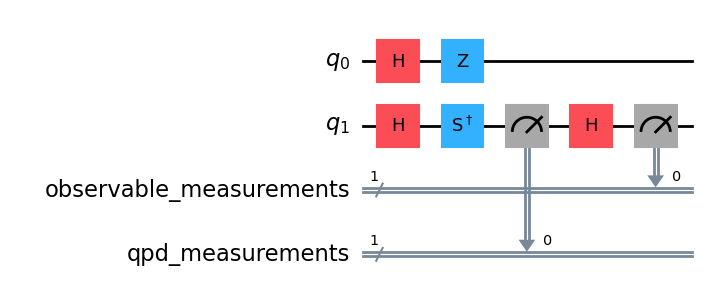

In [10]:
sub_experiments[5].draw('mpl')

Original circuit depth after transpile:  27
QPD sub-experiment depth after transpile:  7
Number of sub-experiments: 6


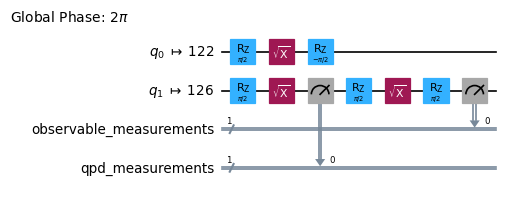

In [11]:
# Transpile the circuit
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, initial_layout=layout, seed_transpiler=0)
isa_qpd_circuit = pm.run(sub_experiments[5])

# depth using circuit cutting
isa_qpd_depth = isa_qpd_circuit.depth()

print(f"Original circuit depth after transpile: ", isa_qc_depth)
print(f"QPD sub-experiment depth after transpile: ", isa_qpd_depth)
print(f"Number of sub-experiments:", len(sub_experiments))
isa_qpd_circuit.draw("mpl", scale=0.6, idle_wires=False, fold=False)

上記の回路は、6つの sub-experiments の5番目の回路です。すべての sub-experiments の Depth を見てみましょう。

In [12]:
x = np.array([c.depth() for c in pm.run(sub_experiments)])
print(x)

[4 3 3 3 7 7]


元の回路の期待値を知るためには、いくつもの sub-experiments を実行しなければなりません。この場合、6つの回路を実行し、サブ・オブザーバブルとサンプリング係数を用いて再構成する必要があります。従って、**Circuit Knittingでは、各回路の深さは大幅に減少しますが、多くの回路を実行する必要があります。**

詳細については、チュートリアル の[Gate Cutting to Reduce Circuit Depth](https://qiskit-extensions.github.io/circuit-knitting-toolbox/circuit_cutting/tutorials/02_gate_cutting_to_reduce_circuit_depth.html) を参照してください。

### Toffoli 回路の Circuit cutting

#### Exercise1: 単一の接続のカット

````{admonition} Exercise
Toffoli ゲートの回路の深さを最小にするためには、どのゲート接続をカットすべきでしょうか？ Toffoli ゲートの各量子ビットが `ibm_kyoto` デバイス上の `[122, 124, 126]` にあると仮定し、1つの接続だけをカットします。以下をを求めてください。abs

- カットするゲートの接続 ({0, 1}など)
- circuit cutting を使用しない場合の深さ(元の回路の深さ)
- circuit cutting を使用した場合の平均の深さ

**注意：** `generate_preset_pass_manager()` の引数として、`optimization_level=1`、`seed_transpiler=0` を使ってください。

```python
##### To know the original circuit depth

##### Write your code below here #####
##### Transpile the circuit




##### Calculate original circuit depth
isa_toffoli_depth = 

##### Don't change any code past this line #####
print(f"Transpiled circuit depth: ", isa_toffoli_depth)
isa_qc.draw("mpl", scale=0.6, idle_wires=False, fold=False)
```
````

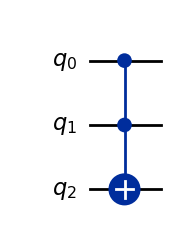

In [13]:
toffoli_layout = [122, 124, 126]

toffoli = QuantumCircuit(3)
toffoli.ccx(0, 1, 2)
toffoli.draw("mpl")

Transpiled circuit depth:  62


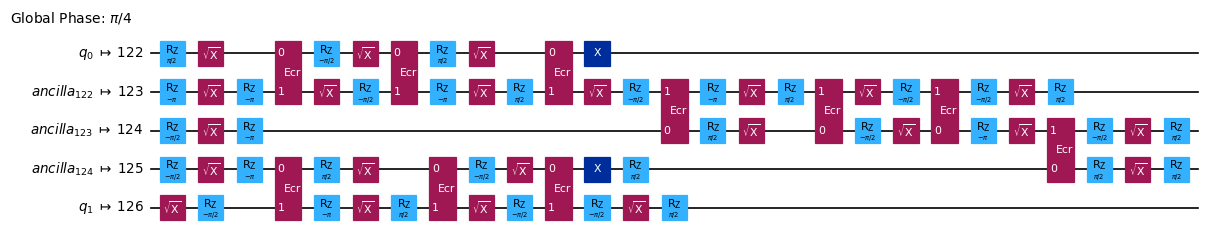

In [14]:
# To know the original circuit depth

### Write your code below here ###
# Transpile the circuit
pm = generate_preset_pass_manager(
    backend=backend,
    optimization_level=1, 
    initial_layout=toffoli_layout,
    seed_transpiler=0)
isa_toffoli = pm.run(toffoli)

# Calculate original circuit depth
isa_toffoli_depth = isa_toffoli.depth()

### Don't change any code past this line ###
print(f"Transpiled circuit depth: ", isa_toffoli_depth)
isa_qc.draw("mpl", scale=0.6, idle_wires=False, fold=False)

回路を切断するために、ISA回路ではなく、decompose された toffoli 回路を使います。

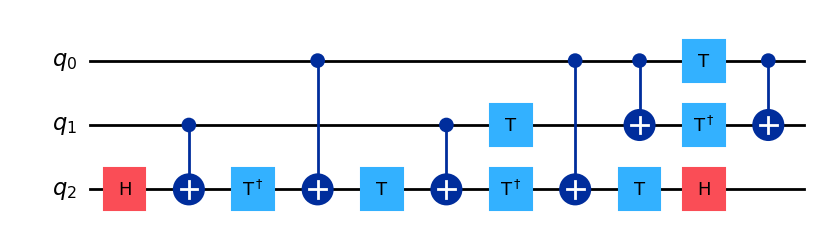

In [15]:
# Decompose the toffoli circuit
toffoli_ = toffoli.decompose()
toffoli_.draw('mpl')

```{note}
ここではq0とq1間のゲート接続`{0, 1}`を切断してみます。
```

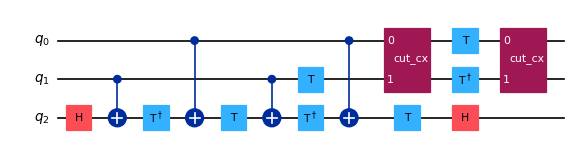

In [16]:
# To know the depth using circuit cutting

### Write your code below here ###
# Find the indices of the distant gates
gates_connecting_to_cut = {0, 1} # Hint: Expected type: set {int, int}. Docs: https://docs.python.org/3/tutorial/datastructures.html#sets

cut_indices = [
    i for i, instruction in enumerate(toffoli_.data)
    if {toffoli_.find_bit(q)[0] for q in instruction.qubits} == gates_connecting_to_cut
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(toffoli_, cut_indices)

### Don't change any code past this line ###

qpd_circuit.draw("mpl", scale=0.6)

Transpiled circuit depth:  62
QPD sub-experiment depth after transpile:  44
Number of sub-experiments: 36


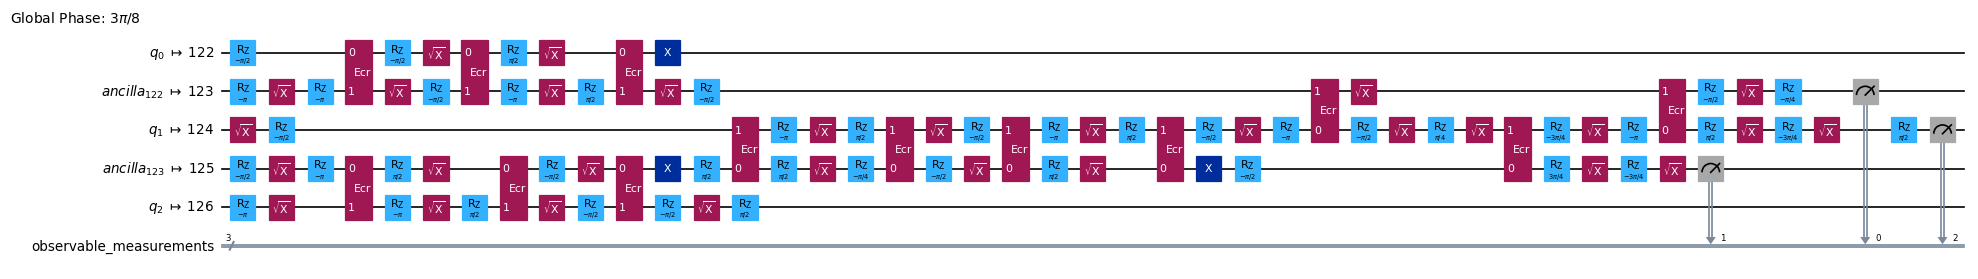

In [17]:
# set the observables
observable = SparsePauliOp(["ZZZ"])

### Write your code below here ###
# Generate the sub-experiments and sampling coefficients
sub_experiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

# Transpile the circuit
# Note: Use optimization_level=1 and seed_transpiler=0
pm = generate_preset_pass_manager(
    backend=backend,
    optimization_level=1,
    initial_layout=toffoli_layout,
    seed_transpiler=0
)
isa_qpd_toffoli = pm.run(sub_experiments[0])

# Depth using circuit cutting
isa_qpd_toffoli_depth = isa_qpd_toffoli.depth()

### Don't change any code past this line ###
print(f"Transpiled circuit depth: ", isa_toffoli_depth)
print(f"QPD sub-experiment depth after transpile: ", isa_qpd_toffoli_depth)
print(f"Number of sub-experiments:", len(sub_experiments))
isa_qpd_toffoli.draw("mpl", scale=0.6, idle_wires=False, fold=False)

In [18]:
### Write your code below here ###
# mean of the depth of all sub-experiments
%time depth_list = np.array([c.depth() for c in pm.run(sub_experiments)])
isa_qpd_toffoli_depth_mean = np.mean(depth_list)

### Don't change any code past this line ###
print(isa_qpd_toffoli_depth_mean)

CPU times: user 6.63 s, sys: 523 ms, total: 7.15 s
Wall time: 19.8 s
44.333333333333336


#### Exercise2: 2つの接続のカット

````{admonition} Exercise
2つの接続をカットすることを考えてみましょう。

Toffoli ゲートの回路の深さを最小にするためには、どの2つのゲート接続をカットすべきでしょうか？ Toffoli ゲートの各量子ビットが`ibm_kyoto` デバイスの `[122, 124, 126]` にあると仮定し、2つの接続をカットします。

**注意：** `generate_preset_pass_manager()` の引数として、`optimization_level=1`、`seed_transpiler=0` を使ってください。

```python
##### Write your code below here #####
##### Find the indices of the distant gates
gates_connecting_to_cut_1 = # Hint: Expected type: set {int, int}
gates_connecting_to_cut_2 = # Hint: Expected type: set {int, int} 

cut_indices = 

##### Decompose distant CNOTs into TwoQubitQPDGate instances


##### Don't change any code past this line #####
qpd_circuit_2.draw("mpl", scale=0.6)


##### set the observables
observable = SparsePauliOp(["ZZZ"])

##### Write your code below here #####
##### Generate the sub-experiments and sampling coefficients

sub_experiments_2, coefficients = 

##### Transpile the circuit
##### Note: Use optimization_level=1 and seed_transpiler=0



##### Depth using circuit cutting
isa_qpd_toffoli_depth_2 =


##### Don't change any code past this line #####
print(f"QPD sub-experiment depth after transpile: ", isa_qpd_toffoli_depth_2)
print(f"Number of sub-experiments:", len(sub_experiments_2))
isa_qpd_circuit_2.draw("mpl", scale=0.6, idle_wires=False, fold=False)
```
````

```{caution}
1 つの条件で実行するのに 1 分以上かかる場合があります。
そのため、結果を比較して解決策を見つけるのに長い時間がかかります。 なぜなら、接続を 2 箇所で切断すると、回路の深さは浅くなりますが、 sub-experiments の数が増えることが予想されるからです。
```

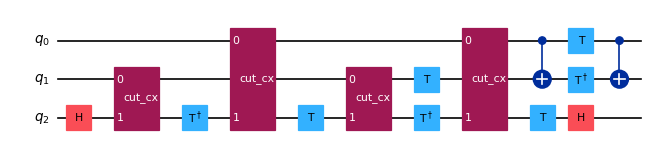

In [19]:
### Write your code below here ###
# Find the indices of the distant gates
gates_connecting_to_cut_1 = {0, 2}# Hint: Expected type: set {int, int}
gates_connecting_to_cut_2 = {1, 2}# Hint: Expected type: set {int, int} 

cut_indices = [
    i for i, instruction in enumerate(toffoli_.data)
    if {toffoli_.find_bit(q)[0] for q in instruction.qubits} in (gates_connecting_to_cut_1, gates_connecting_to_cut_2)
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit_2, bases = cut_gates(toffoli_, cut_indices)

### Don't change any code past this line ###
qpd_circuit_2.draw("mpl", scale=0.6)

QPD sub-experiment depth after transpile:  21
Number of sub-experiments: 1296


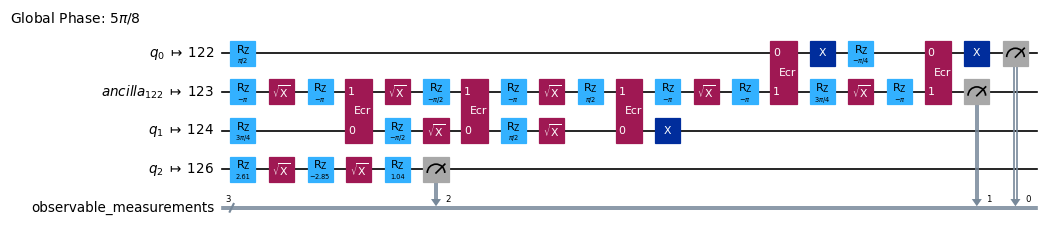

In [20]:
# set the observables
observable = SparsePauliOp(["ZZZ"])

### Write your code below here ###
# Generate the sub-experiments and sampling coefficients

sub_experiments_2, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit_2, observables=observable.paulis, num_samples=np.inf
)

# Transpile the circuit
# Note: Use optimization_level=1 and seed_transpiler=0
pm = generate_preset_pass_manager(
    backend=backend,
    optimization_level=1,
    initial_layout=toffoli_layout,
    seed_transpiler=0
)
isa_qpd_circuit_2 = pm.run(sub_experiments_2[0])


# Depth using circuit cutting
isa_qpd_toffoli_depth_2 = isa_qpd_circuit_2.depth()


### Don't change any code past this line ###
print(f"QPD sub-experiment depth after transpile: ", isa_qpd_toffoli_depth_2)
print(f"Number of sub-experiments:", len(sub_experiments_2))
isa_qpd_circuit_2.draw("mpl", scale=0.6, idle_wires=False, fold=False)

1000 を超える sub-experiments が必要になることがわかります。そのため、平均回路深さを計算する次のセルの実行には少し時間がかかります。

In [21]:
### Write your code below here ###
# mean of the depth of all sub-experiments
%time depth_list_2 = np.array([c.depth() for c in pm.run(sub_experiments_2)])
isa_qpd_toffoli_depth_2_mean = np.mean(depth_list_2)

### Don't change any code past this line ###
print(isa_qpd_toffoli_depth_2_mean)

CPU times: user 17.3 s, sys: 8.53 s, total: 25.9 s
Wall time: 8min 3s
21.246913580246915


## 結果の可視化

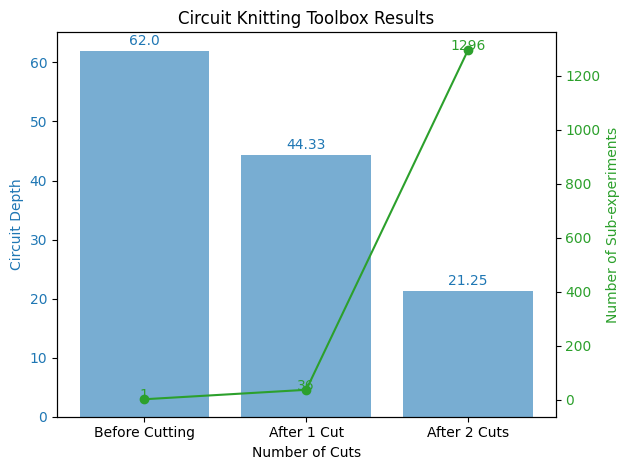

In [22]:
# Number of sub-experiments
num_sub_experiments_1_cut = len(sub_experiments)
num_sub_experiments_2_cut = len(sub_experiments_2)

# Data for plotting
categories = ['Before Cutting', 'After 1 Cut', 'After 2 Cuts']
depth_values = [isa_toffoli_depth, isa_qpd_toffoli_depth_mean, isa_qpd_toffoli_depth_2_mean]
num_sub_experiments = [1, num_sub_experiments_1_cut, num_sub_experiments_2_cut]

# Create figure and axis
fig, ax1 = plt.subplots()

# Plot depth values
color = 'tab:blue'
ax1.set_xlabel('Number of Cuts')
ax1.set_ylabel('Circuit Depth', color=color)
bars = ax1.bar(categories, depth_values, color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)

# Add value labels on bars
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval + 1, round(yval, 2), ha='center', color=color, fontsize=10)

# Create a second y-axis to plot the number of subexperiments
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Number of Sub-experiments', color=color)
ax2.plot(categories, num_sub_experiments, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Add value labels on points
for i, num in enumerate(num_sub_experiments):
    ax2.text(i, num + 0.1, num, ha='center', color=color, fontsize=10)

# Add titles and labels
plt.title('Circuit Knitting Toolbox Results')
fig.tight_layout()  # Adjust layout to make room for both y-axes

# Show plot
plt.show()

```{note}
カットする接続数を増やすほど回路の深さが減少していることが確認できました。  
一方で必要となるsub experimentsの数は増えています（2つの接続をカットすると1000以上のsub experimentが必要！）。

このトレードオフを念頭にゲートカットの戦略を検討する必要がありそうです。
```

## 追加情報

**Created by:** Kifumi Numata

**Advised by:** Jennifer Glick, Junye Huang, Vishal Sharathchandra Bajpe

**Version:** 1.1.0